In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/air-quality-index/test.csv
/kaggle/input/air-quality-index/train.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/air-quality-index/train.csv')
df_test = pd.read_csv('/kaggle/input/air-quality-index/test.csv')
print('Training data info',df_train.info())
print(10*'--')
print('Testing data info:',df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 14 columns):
date_time              33750 non-null object
is_holiday             33750 non-null object
humidity               33750 non-null int64
wind_speed             33750 non-null int64
wind_direction         33750 non-null int64
visibility_in_miles    33750 non-null int64
dew_point              33750 non-null int64
temperature            33750 non-null float64
rain_p_h               33750 non-null float64
snow_p_h               33750 non-null float64
clouds_all             33750 non-null int64
weather_type           33750 non-null object
air_pollution_index    33750 non-null int64
traffic_volume         33750 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 3.6+ MB
Training data info None
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14454 entries, 0 to 14453
Data columns (total 13 columns):
date_time              14454 non-null object
is_ho

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline

In [4]:
#looking the data
df_train.head(10)

,date_time,is_holiday,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
0,2012-10-02 09:00:00,None,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,121,5545
1,2012-10-02 10:00:00,None,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,178,4516
2,2012-10-02 11:00:00,None,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,113,4767
3,2012-10-02 12:00:00,None,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,20,5026
4,2012-10-02 13:00:00,None,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,281,4918
5,2012-10-02 14:00:00,None,65,3,328,6,6,291.72,0.0,0.0,1,Clear,23,5181
6,2012-10-02 15:00:00,None,64,3,328,7,7,293.17,0.0,0.0,1,Clear,184,5584
7,2012-10-02 16:00:00,None,64,3,327,7,7,293.86,0.0,0.0,1,Clear,167,6015
8,2012-10-02 17:00:00,None,63,3,327,6,6,294.14,0.0,0.0,20,Clouds,119,5791
9,2012-10-02 18:00:00,None,63,3,326,3,3,293.10,0.0,0.0,20,Clouds,161,4770


In [5]:
# change date column from object to date-time format
df_train['date_time'] = pd.to_datetime(df_train['date_time'])

#drop holiday column because most of the value is none (normal day) therefore has no significant impact
df_train.drop('is_holiday', axis=1, inplace=True)

#change wather_type column to representative number using Ordinal encoder
encoder = OrdinalEncoder()
weather = df_train[['weather_type']]
weather_enc = encoder.fit_transform(weather)
df_train['weather_type'] = weather_enc

In [6]:
df_train.head(2)

,date_time,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
0,2012-10-02 09:00:00,89,2,329,1,1,288.28,0.0,0.0,40,1.0,121,5545
1,2012-10-02 10:00:00,67,3,330,1,1,289.36,0.0,0.0,75,1.0,178,4516


In [7]:
encoder.categories_

[array(['Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain',
        'Smoke', 'Snow', 'Squall', 'Thunderstorm'], dtype=object)]

In [8]:
df_train.describe()

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
count,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000
mean,71.209007,3.378193,199.471852,4.989748,4.989748,280.069587,0.448739,0.000318,50.458785,2.520000,154.841422,3240.118163
std,16.852248,2.055792,99.841088,2.570021,2.570021,13.415256,53.526500,0.009760,38.871734,2.739005,83.735515,1991.487289
min,13.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,60.000000,2.000000,130.000000,3.000000,3.000000,271.720000,0.000000,0.000000,1.000000,0.000000,83.000000,1165.250000
50%,72.000000,3.000000,200.000000,5.000000,5.000000,280.150000,0.000000,0.000000,64.000000,1.000000,155.000000,3335.000000
75%,85.000000,5.000000,290.000000,7.000000,7.000000,290.620000,0.000000,0.000000,90.000000,5.000000,228.000000,4926.000000
max,100.000000,16.000000,360.000000,9.000000,9.000000,308.240000,9831.300000,0.510000,100.000000,10.000000,299.000000,7280.000000


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


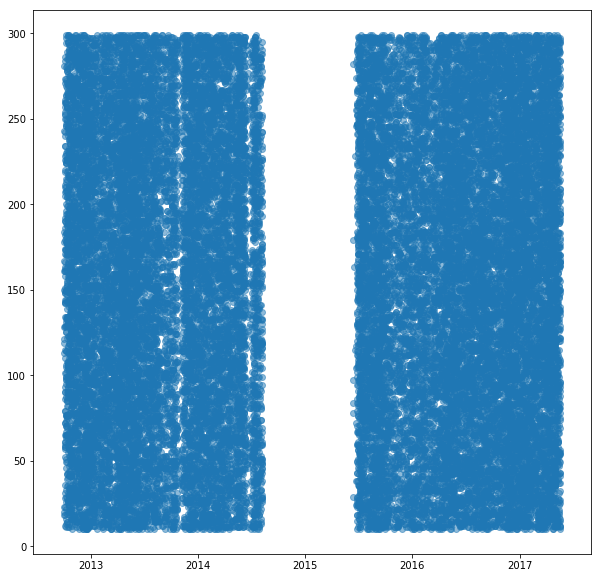

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(df_train['date_time'], df_train['air_pollution_index'], marker='o', alpha=0.5);

In [10]:
date = df_train['date_time']
print(date.min(),'|||||' ,date.max())

2012-10-02 09:00:00 ||||| 2017-05-17 23:00:00


In [11]:
#avarging value to daily instead of hourly
df_train.set_index('date_time', inplace=True)
df_train_D = df_train.resample('D').mean()
df_train_D.head(2)
#weather_type column now to be avarge value too, i keep this value to see how it impact the model later

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
date_time,,,,,,,,,,,,
2012-10-02,65.2,3.133333,327.2,4.933333,4.933333,290.403333,0.0,0.0,29.133333,0.533333,139.466667,4219.266667
2012-10-03,51.8,4.400000,326.6,3.700000,3.700000,286.413500,0.0,0.0,3.850000,0.150000,154.650000,3317.250000


In [12]:
df_train_D.tail(3)

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
date_time,,,,,,,,,,,,
2017-05-15,73.866667,2.200000,209.466667,4.566667,4.566667,290.611000,0.0,0.0,39.300000,3.133333,164.100000,3809.166667
2017-05-16,76.666667,3.595238,219.595238,4.261905,4.261905,291.871429,0.0,0.0,57.214286,5.738095,154.952381,3594.476190
2017-05-17,72.052632,2.052632,294.982456,4.859649,4.859649,290.175965,0.0,0.0,87.456140,5.473684,157.754386,3482.456140


In [13]:
df_train_D.dropna(axis=0, inplace=True)
df_train_D.isna().sum()

humidity               0
wind_speed             0
wind_direction         0
visibility_in_miles    0
dew_point              0
temperature            0
rain_p_h               0
snow_p_h               0
clouds_all             0
weather_type           0
air_pollution_index    0
traffic_volume         0
dtype: int64

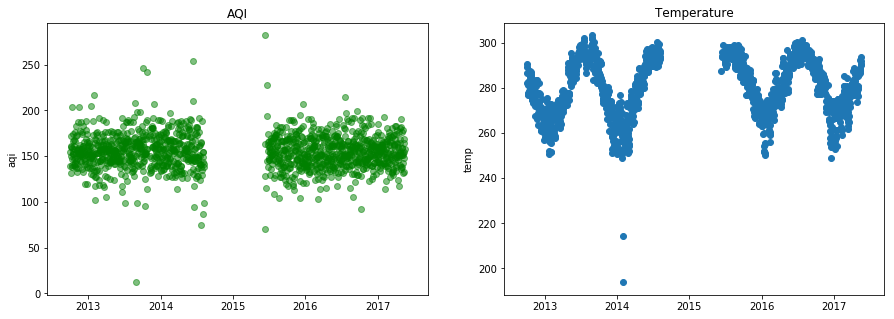

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(df_train_D.index, df_train_D['air_pollution_index'], alpha=0.5, c='g', )
plt.title('AQI'); plt.ylabel('aqi')

plt.subplot(1,2,2)
plt.scatter(df_train_D.index, df_train_D['temperature'])
plt.title('Temperature'); plt.ylabel('temp');

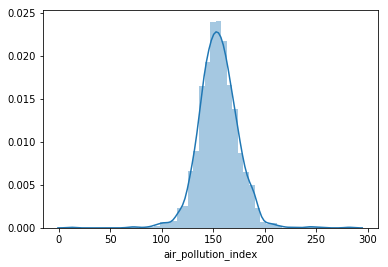

In [15]:
sns.distplot(df_train_D['air_pollution_index'],);

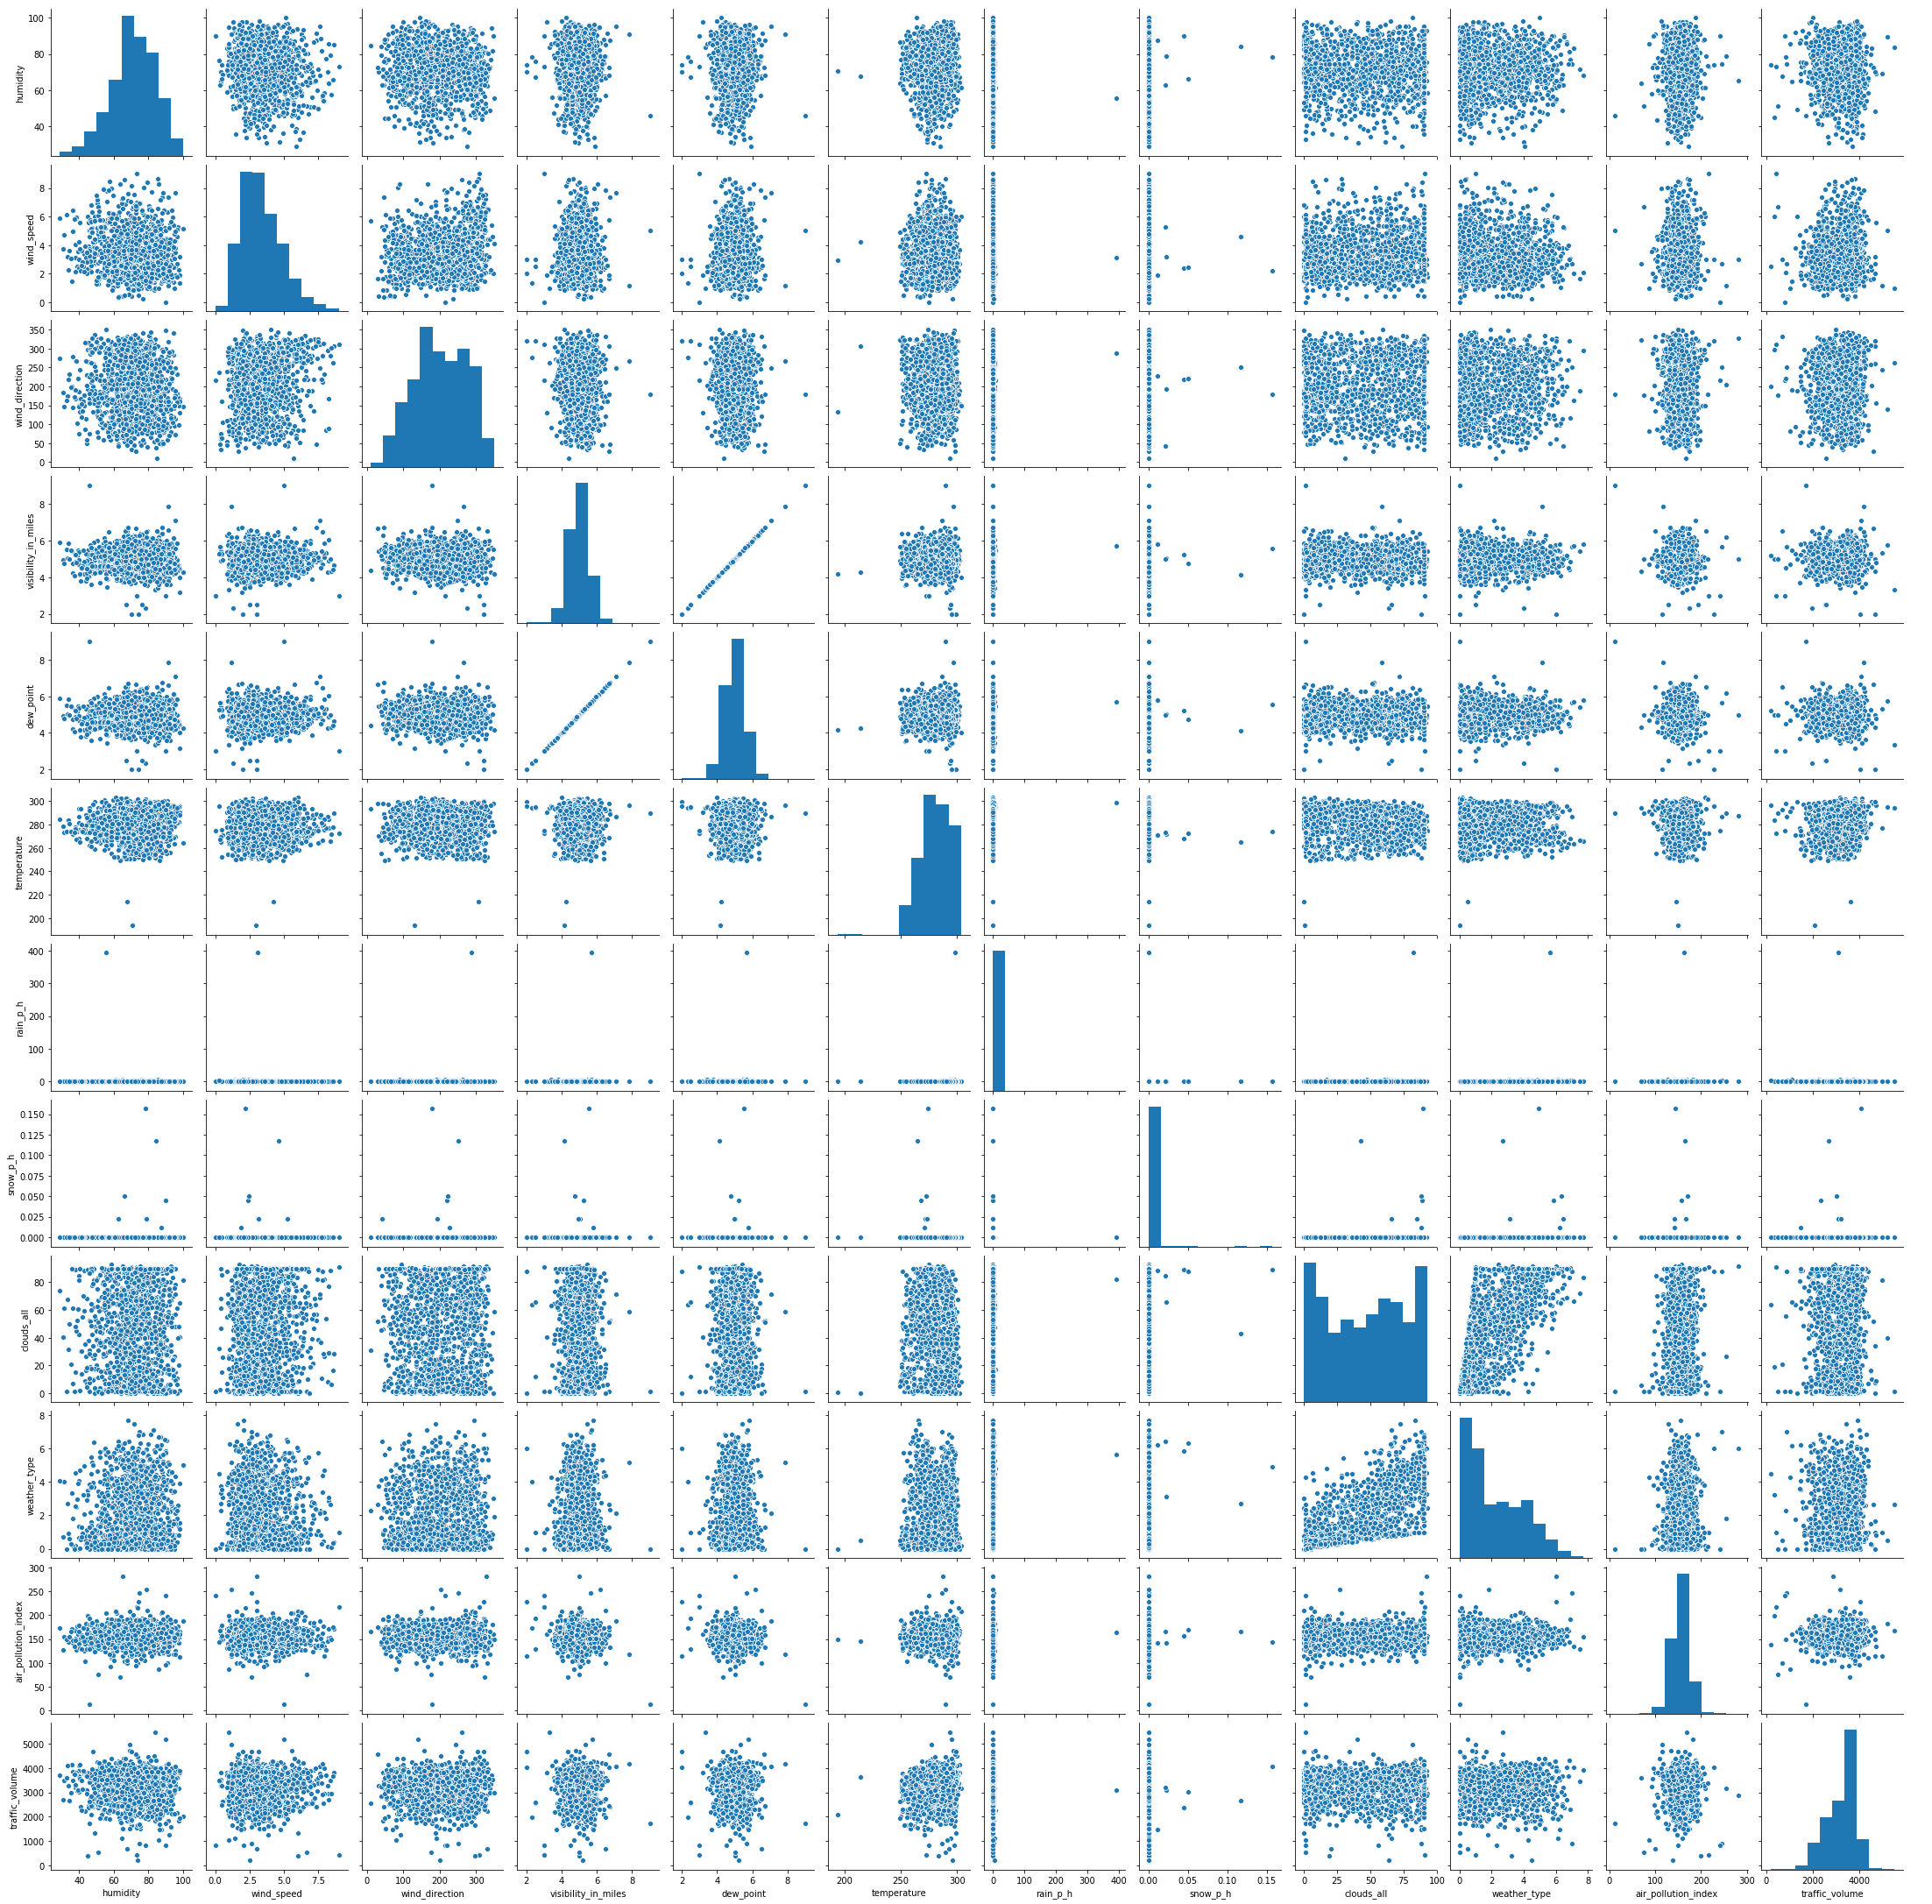

In [16]:
sns.pairplot(df_train_D)

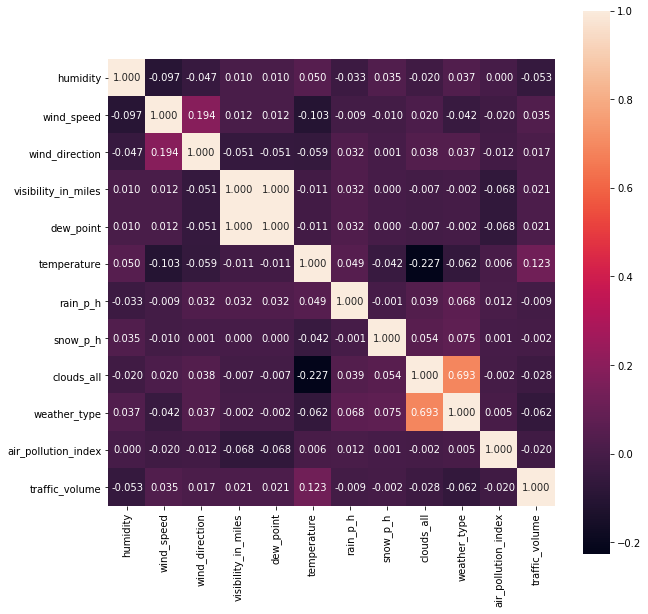

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train_D.corr(), annot=True, fmt='0.3f', square=True)

In [18]:
#since weather type is ordinal number that has been avaraging and has higher corellation with clouds_all so i just drop it
df_train_D.drop('weather_type', axis=1, inplace=True)
#splitting data and its label
X_train, y_train = df_train_D.drop(['air_pollution_index'], axis=1), df_train_D['air_pollution_index']

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

S_scaler = StandardScaler()
MX_Scaler = MinMaxScaler ()
X_train_S_Scal = S_scaler.fit_transform(X_train)
X_train_MX_Scal = MX_Scaler.fit_transform(X_train)

In [20]:
X_train_S_Scal.shape

(1359, 10)

In [21]:
models = {'lrg':LinearRegression(), 'SVR': SVR(), 'KNN':KNeighborsRegressor(), 'RFR':RandomForestRegressor(), 'GBR': GradientBoostingRegressor(),
         'Tree': DecisionTreeRegressor()}

def model_evaluate(model, X_train, y_train):
    score = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    return np.sqrt(-score)

def scoring_mean_std(val):
    mse = {}
    for key, value in val.items():
        mse[key] = (value.mean(), value.std())
    return mse

In [22]:
def modelc_cv_score(X_train, y_train):
    val= {}
    for key, value in models.items():
        val[key] = model_evaluate(value, X_train, y_train)
    return val
val_MinMax_Scaller = modelc_cv_score(X_train_MX_Scal, y_train=y_train)
val_SS_Scaller = modelc_cv_score(X_train_S_Scal, y_train)

In [23]:
scoring_mean_std(val_MinMax_Scaller)

{'lrg': (20.03670534081715, 4.48781398163558),
 'SVR': (18.946208320689742, 3.9457601547353476),
 'KNN': (21.064687983772615, 3.9240878770019836),
 'RFR': (20.223182552042935, 4.982113970465805),
 'GBR': (20.21727266124705, 4.970084631237122),
 'Tree': (27.566142843029517, 5.4276037438661575)}

In [24]:
scoring_mean_std(val_SS_Scaller)

{'lrg': (35559940480247.734, 106679821440682.58),
 'SVR': (19.011646669730805, 3.9630808038109584),
 'KNN': (21.076986500395382, 4.034936794161119),
 'RFR': (20.22235135438076, 5.1094707103961845),
 'GBR': (20.115115550894703, 4.830725750284326),
 'Tree': (27.47442019694959, 5.079847209952381)}

In [25]:
#SVR Has minimum score, it's tuning the parameters now
from sklearn.model_selection import GridSearchCV

svr = SVR()
param = [{"C": [0.01, 0.1, 0.5, 1, 10, 100], 'degree':[3,4,5,6,7]}]
grid_search = GridSearchCV(svr, param_grid=param, scoring='neg_mean_squared_error' ,return_train_score=True, cv=10)
grid_search.fit(X_train_MX_Scal, y_train)
grid_search.best_estimator_

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
svr = SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
          kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr.fit(X_train_MX_Scal, y_train)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
# change date column from object to date-time format
df_test['date_time'] = pd.to_datetime(df_test['date_time'])

#drop holiday column because most of the value is none (normal day) therefore has no significant impact
df_test.drop(['is_holiday', 'weather_type'], axis=1, inplace=True)

df_test.set_index('date_time', inplace=True)
df_test_D = df_test.resample('D').mean()
df_test_D.head(2)

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume
date_time,,,,,,,,,,
2017-05-18,61.952381,2.428571,138.785714,4.095238,4.095238,283.322857,0.0,0.0,84.214286,3359.047619
2017-05-19,66.375000,3.041667,208.625000,5.958333,5.958333,282.230417,0.0,0.0,39.083333,3770.916667


In [28]:
df_test_D.isnull().sum()

humidity               0
wind_speed             0
wind_direction         0
visibility_in_miles    0
dew_point              0
temperature            0
rain_p_h               0
snow_p_h               0
clouds_all             0
traffic_volume         0
dtype: int64

In [29]:
df_test_scaled = MX_Scaler.transform(df_test_D)

df_test_D['AQI'] = svr.predict(df_test_scaled)
df_test_D

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume,AQI
date_time,,,,,,,,,,,
2017-05-18,61.952381,2.428571,138.785714,4.095238,4.095238,283.322857,0.000000,0.0,84.214286,3359.047619,154.411853
2017-05-19,66.375000,3.041667,208.625000,5.958333,5.958333,282.230417,0.000000,0.0,39.083333,3770.916667,154.482488
2017-05-20,83.086957,3.282609,206.804348,5.521739,5.521739,280.901087,0.000000,0.0,89.673913,3123.760870,154.307245
2017-05-21,86.127273,2.054545,295.654545,5.454545,5.454545,282.432182,0.000000,0.0,90.000000,2483.400000,154.337133
2017-05-22,75.500000,1.192308,208.000000,5.538462,5.538462,285.205000,0.000000,0.0,47.692308,3309.730769,154.461635
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,64.500000,5.083333,216.958333,4.708333,4.708333,283.995833,0.010417,0.0,39.833333,3692.791667,154.467212
2018-09-27,50.240000,4.040000,246.280000,5.320000,5.320000,286.268400,0.020000,0.0,61.200000,3777.360000,154.435913
2018-09-28,52.250000,4.958333,232.083333,5.666667,5.666667,281.588333,0.000000,0.0,26.250000,3854.916667,154.525702


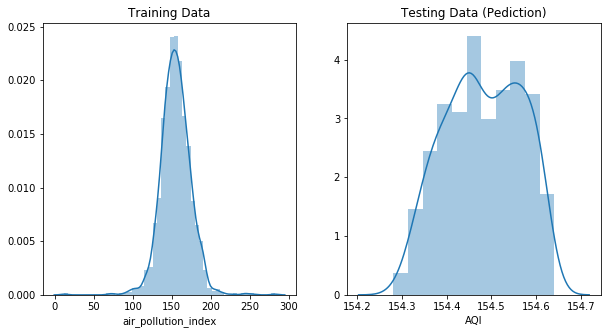

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(df_train_D['air_pollution_index'], norm_hist=True)
plt.title('Training Data')
plt.subplot(1,2,2)
sns.distplot(df_test_D['AQI'], norm_hist=True);
plt.title('Testing Data (Pediction)');

In [31]:
df_test_D['AQI'].median()

154.47996144364512

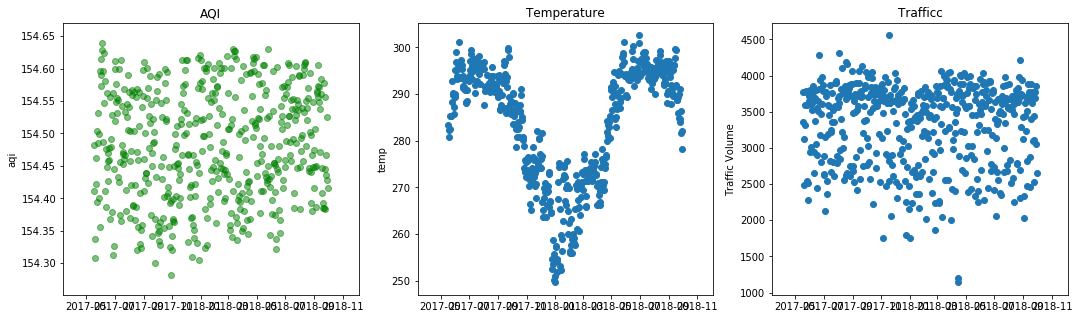

In [32]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.scatter(df_test_D.index, df_test_D['AQI'], alpha=0.5, c='g', )
plt.title('AQI'); plt.ylabel('aqi')

plt.subplot(1,3,2)
plt.scatter(df_test_D.index, df_test_D['temperature'])
plt.title('Temperature'); plt.ylabel('temp');

plt.subplot(1,3,3)
plt.scatter(df_test_D.index, df_test_D['traffic_volume'])
plt.title('Trafficc'); plt.ylabel('Traffic Volume');